In [91]:
import numpy as np
import pandas as pd
import sys
# import tensorflow as tf
from tensorflow.keras import utils # utils.to_categorical 원핫인코딩
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt # 학습 과정 그래프
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # 데이터 분리
import openpyxl

# 이진분류
```
1. 데이터 셋 생성 & 전처리
    엑셀->데이터프레임 -> 처리(df.replace('?',np,nan)) -> 결측치 처리
    -> X, y 분리 -> X변수 스케일 조정 -> train_test_split 함수로 학습셋과 테스트셋 분리
2. 모델 생성(입력13, 출력1) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```

### 컬럼명   의미 및 설명

- cp   흉통의 유형 (Chest Pain type)
    - 0: 전형적 협심증 / 1: 비전형적 협심증 / 2: 비심장성 흉통 / 3: 무증상
- treshtbps   안정 시 수축기 혈압 (Resting Blood Pressure in mm Hg)
- chol   혈청 콜레스테롤 수치 (Serum Cholesterol in mg/dl)
- fbs   공복혈당 120mg/dl 이상 여부 (Fasting Blood Sugar) - 1: Yes, 0: No
- restecg   안정 시 심전도 결과 (Resting Electrocardiographic Results)
    - 0: 정상 / 1: ST-T 이상 / 2: 좌심실 비대 가능성
- thalach   최대 심박수 (Maximum Heart Rate Achieved)
- exang   운동 중 협심증 여부 (Exercise Induced Angina) - 1: 있음, 0: 없음
- oldpeak   운동 후 ST 감소 정도 (ST Depression induced by exercise relative to rest)
- slope   ST segment의 기울기 (Slope of the peak exercise ST segment)
    - 1: 수평  / 2: 상승  / 3: 하강
- ca   형광투시검사에서 관찰된 주요 혈관 수 (Number of major vessels colored by fluoroscopy)
- hsl (일반적으로 thal로 표기됨)   지혈소 상태 (Thalassemia)
    - 3: 정상 / 6: 고정결함 / 7: 가역적 결함
- heartDisease   심장병 여부 (Target Variable)
    - 1: 심장병 있음 / 0: 없음

In [39]:
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.isin(['?']).any() # 물음표가 있는 열 여부

age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [40]:
dataset.replace('?', np.nan, inplace=True)
dataset = dataset.apply(lambda x: x.fillna(x.median()) if x.dtype != 'O' else x)

print(dataset.isnull().sum())
print(dataset.info())

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    float64
 12  hsl           303 non-n

In [41]:
In = dataset.iloc[:, :-1]
Target = dataset.iloc[:, -1:]

In.shape, Target.shape

((303, 13), (303, 1))

In [42]:
scaler = MinMaxScaler()
Input_scaled = scaler.fit_transform(In)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Input_scaled, Target, test_size=0.3, random_state=7,
    stratify=y # 층화추출
)


In [44]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(212, 13) (91, 13)
(212, 1) (91, 1)


In [45]:
# 음성|양성 비율
print(pd.DataFrame(y).value_counts(normalize=True)) # 전체 데이터
print(pd.DataFrame(y_train).value_counts(normalize=True)) # y_train
print(pd.DataFrame(y_test).value_counts(normalize=True)) # y_test

0    0.541254
1    0.458746
dtype: float64
heartDisease
0               0.542453
1               0.457547
dtype: float64
heartDisease
0               0.538462
1               0.461538
dtype: float64


In [60]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                896       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 150)               9750      
                                                                 
 dropout_4 (Dropout)         (None, 150)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               15100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 50)               

In [61]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [62]:
hist = model.fit(
    X_train, y_train,
    epochs=200,
    verbose=1,
    validation_split=0.2 
)


Epoch 1/200
6/6 [==============================] - 1s 58ms/step - loss: 0.6949 - accuracy: 0.4793 - recall_2: 0.1316 - precision_2: 0.3125 - val_loss: 0.6757 - val_accuracy: 0.7442 - val_recall_2: 0.7143 - val_precision_2: 0.7500
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6739 - accuracy: 0.7160 - recall_2: 0.6316 - precision_2: 0.7059 - val_loss: 0.6565 - val_accuracy: 0.6977 - val_recall_2: 0.7619 - val_precision_2: 0.6667
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6438 - accuracy: 0.7929 - recall_2: 0.8158 - precision_2: 0.7470 - val_loss: 0.6305 - val_accuracy: 0.7209 - val_recall_2: 0.7143 - val_precision_2: 0.7143
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 0.6142 - accuracy: 0.7456 - recall_2: 0.6447 - precision_2: 0.7538 - val_loss: 0.5980 - val_accuracy: 0.7209 - val_recall_2: 0.7143 - val_precision_2: 0.7143
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.5618 - acc

In [63]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_2', 'precision_2', 'val_loss', 'val_accuracy', 'val_recall_2', 'val_precision_2'])

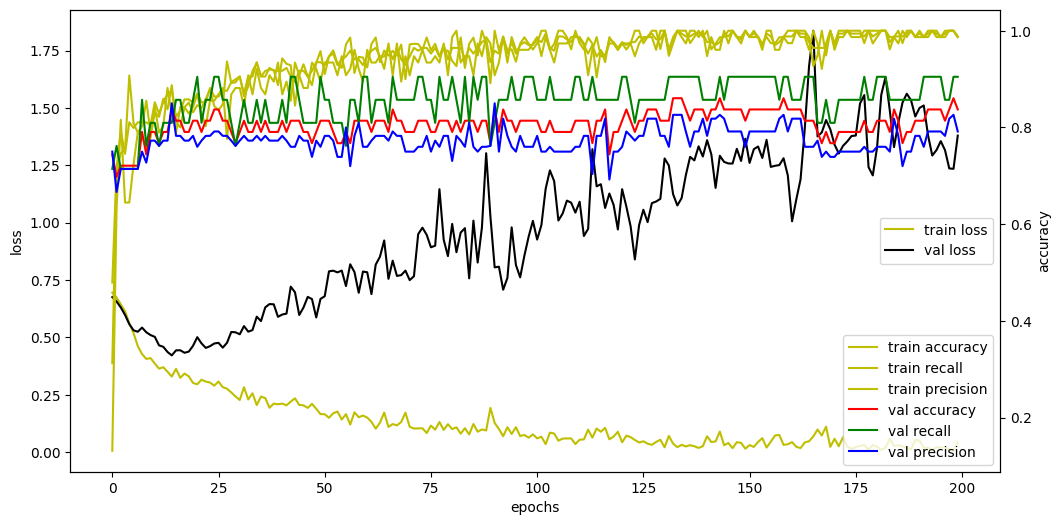

In [65]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'k', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'y', label='train accuracy')
acc_ax.plot(hist.history['recall_2'], 'y', label='train recall')
acc_ax.plot(hist.history['precision_2'], 'y', label='train precision')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val accuracy')
acc_ax.plot(hist.history['val_recall_2'], 'g', label='val recall')
acc_ax.plot(hist.history['val_precision_2'], 'b', label='val precision')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [67]:
score = model.evaluate(X_test, y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  1.4821213483810425
model accuracy :  0.8241758346557617
model recall :  0.8571428656578064
model precision :  0.782608687877655


# 이진분류 2

In [70]:
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.info() # dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [71]:
dataset.isin(['?']).any() # 물음표가 있는 열 여부

age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [72]:
# '?'가 포함된 데이터 추출
dataset[(dataset['chol']=='?') | (dataset['ca']=='?') | (dataset['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [73]:
# '?'를 결측치(np.nan)로 대체
df = dataset.replace('?', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [74]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [75]:
# 결측치 처리 : 대체 or 제거
df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체
# df = df.dropna(how='any')  #결측치 제거
df.isna().sum() # 결측치가 없는지 확인

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [76]:
# Target변수의 분포(0:음성, 1:양성)
print(df['heartDisease'].value_counts()) 
negative, positive = df['heartDisease'].value_counts()
total = df.shape[0]
# print('음성 결과 :', negative/total)
# print('양성 결과 :', positive/total)
print(df['heartDisease'].value_counts(normalize=True))

0    164
1    139
Name: heartDisease, dtype: int64
0    0.541254
1    0.458746
Name: heartDisease, dtype: float64


In [77]:
# 입력변수와 타겟변수 분리
X = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
X.shape, y.shape

((303, 13), (303, 1))

In [78]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[:2]

array([[0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
        1.        , 1.        , 0.60305344, 0.        , 0.37096774,
        1.        , 0.        , 0.75      ],
       [0.79166667, 1.        , 1.        , 0.62264151, 0.3652968 ,
        0.        , 0.        , 0.28244275, 1.        , 0.24193548,
        0.5       , 1.        , 0.        ]])

In [79]:
#scaled_X, y를 학습셋:테스트셋=7:3으로 분할
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                   y,
                                                   test_size=0.3, # 테스트셋비율
                                                   random_state=7,
                                                   stratify=y # 층화추출
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212, 1), (91, 1))

In [80]:
# 음성|양성 비율
print(pd.DataFrame(y).value_counts(normalize=True)) # 전체 데이터
print(pd.DataFrame(y_train).value_counts(normalize=True)) # y_train
print(pd.DataFrame(y_test).value_counts(normalize=True)) # y_test

0    0.541254
1    0.458746
dtype: float64
0    0.542453
1    0.457547
dtype: float64
0    0.538462
1    0.461538
dtype: float64


## 2. 모델 생성(입력13, 출력1) & 학습과정 설정 & 학습
- 그래프를 보고 과적합 줄이기 추가할 수 있음

In [81]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                448       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_28 (Dense)            (None, 1)                

In [82]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [83]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

CPU times: total: 13.6 s
Wall time: 10.7 s


In [84]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3'])

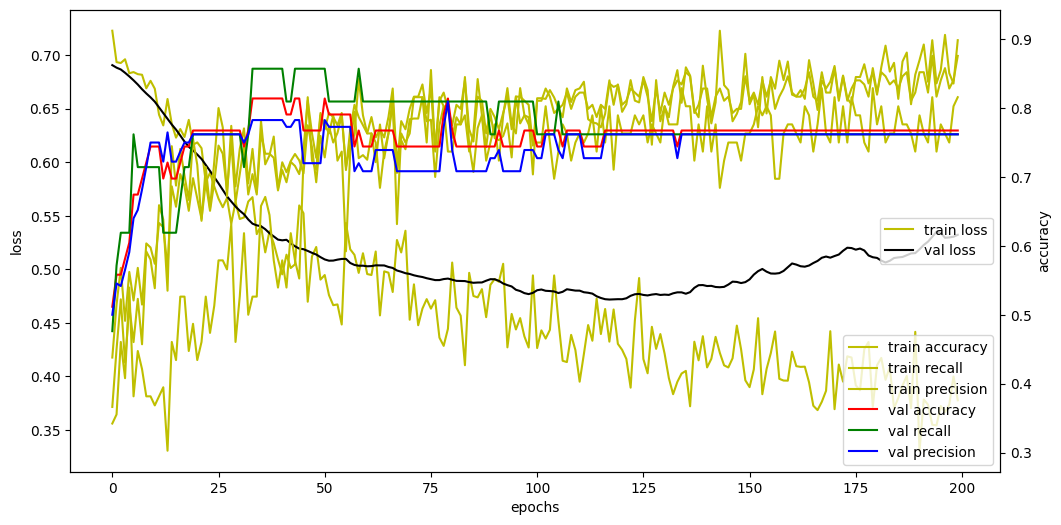

In [86]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'k', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'y', label='train accuracy')
acc_ax.plot(hist.history['recall_3'], 'y', label='train recall')
acc_ax.plot(hist.history['precision_3'], 'y', label='train precision')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val accuracy')
acc_ax.plot(hist.history['val_recall_3'], 'g', label='val recall')
acc_ax.plot(hist.history['val_precision_3'], 'b', label='val precision')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [87]:
score = model.evaluate(X_test, y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  0.3622948229312897
model accuracy :  0.8571428656578064
model recall :  0.8571428656578064
model precision :  0.8372092843055725


In [88]:
# 교차표
y_test.reshape(-1) # 실제값

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0], dtype=int64)

In [89]:
y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
pd.crosstab(y_test.reshape(-1), y_hat, 
           rownames=['실제값'], colnames=['예측값'])

3/3 [==============================] - 0s 3ms/step


예측값,0,1
실제값,,
0,42,7
1,6,36


# 4. 모델 사용

# 분류분석
```
1. 데이터 셋 생성 & 전처리
    엑셀->데이터프레임 -> 처리(df.replace('?',np,nan)) -> 결측치 처리
    -> X, y 분리 -> X변수 스케일 조정 -> train_test_split 함수로 학습셋과 테스트셋 분리
    -> y 변수들의 원핫 인코딩
2. 모델 생성(입력13, 출력2) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```

In [92]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((212, 2), (91, 2))

In [93]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2,  activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 32)                448       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_31 (Dense)            (None, 8)                 136       
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_32 (Dense)            (None, 2)                

In [94]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [98]:
hist = model.fit(X_train, Y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

TypeError: 'NoneType' object is not callable